<a href="https://colab.research.google.com/github/gibiee/Measure_BoneAge/blob/master/%EB%BC%88%20%EB%82%98%EC%9D%B4%20%EC%B8%A1%EC%A0%95(Male%20%EC%A0%84%EC%9A%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q "./drive/My Drive/양재 팀프로젝트/뼈 나이 측정/BoneAge_Dataset.zip" -d dataset
!ls

dataset  drive	sample_data


In [ ]:
import tensorflow as tf

# male_model = tf.keras.applications.Xception(weights=None, include_top=True, input_shape=(224,224,1), classes=1, classifier_activation=None)
male_model = tf.keras.applications.InceptionV3(weights=None, include_top=True, input_shape=(224,224,1), classes=1, classifier_activation=None)

# print(model.summary())

In [ ]:
# #'''
# # 각 레이어에서 어떤 activation function을 쓰는지 확인
# for layer in model.layers :
#     try :
#         print(layer.activation)
#     except:
#         print("Activation function 없음")
# '''

In [ ]:
male_model.compile(loss='mae', optimizer='adam')

In [ ]:
import pandas as pd

csv_train=pd.read_csv('./dataset/train_csv.csv')
csv_train.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [ ]:
for i in range(len(csv_train['id'])):
  csv_train.loc[i,"id"] = f"{csv_train['id'][i]}.png"

csv_train.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


In [ ]:
male_df = csv_train.loc[csv_train.male == True]
male_df.head()

,id,boneage,male
3,1380.png,120,True
5,1382.png,138,True
6,1383.png,150,True
7,1384.png,156,True
8,1385.png,36,True


In [ ]:
len(male_df)

6833

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(male_df, directory='./dataset/train/', x_col='id', y_col='boneage',
                                              target_size=(224,224), color_mode='grayscale',
                                              class_mode='raw', subset='training')
valid_generator = datagen.flow_from_dataframe(male_df, directory='./dataset/train/', x_col='id', y_col='boneage',
                                              target_size=(224,224), color_mode='grayscale', 
                                              class_mode='raw', subset='validation', shuffle=False)

Found 5467 validated image filenames.
Found 1366 validated image filenames.


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True,
                                                filepath="./drive/My Drive/양재 팀프로젝트/뼈 나이 측정/checkpoint_male.h5")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = male_model.fit_generator(train_generator, validation_data=valid_generator, epochs=100, callbacks=[checkpoint, early_stopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
171/171 [==============================] - ETA: 0s - loss: 62.0989WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./drive/My Drive/양재 팀프로젝트/뼈 나이 측정/checkpoint_male.tf/assets
171/171 [==============================] - 254s 1s/step - loss: 62.0989 - val_loss: 36.7007
Epoch 2/100
171/171 [==============================] - 200s 1s/step - loss: 17.8929 - val_loss: 72.9564
Epoch 3/100
171/171 [==============================] - 225s 1s/step - loss: 15.0015

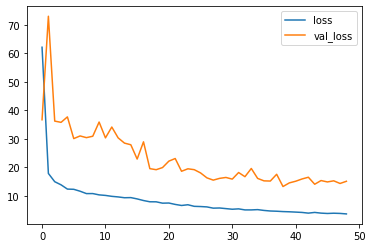

In [ ]:
# 학습 과정에서의 loss와 val_loss 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
# 예측값과 정답값을 비교
load_model = tf.keras.models.load_model("./drive/My Drive/양재 팀프로젝트/뼈 나이 측정/checkpoint_male.h5")

predict = load_model.predict_generator(valid_generator).flatten()

compare = pd.DataFrame({"id" : valid_generator.filenames,
                        "예측" : predict,
                        "정답" : valid_generator.labels})
compare.head(20)

Instructions for updating:
Please use Model.predict, which supports generators.


,id,예측,정답
0,1380.png,157.439316,120
1,1382.png,146.490997,138
2,1383.png,152.178116,150
3,1384.png,126.375023,156
4,1385.png,28.077801,36
5,1387.png,136.836365,138
6,1389.png,145.586807,138
7,1390.png,162.727707,156
8,1391.png,182.268143,180
9,1394.png,92.945076,57


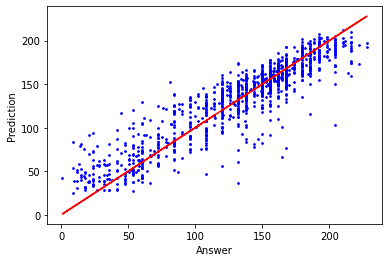

In [ ]:
# 최종 결과값과 예측값 비교 시각화
import matplotlib.pyplot as plt

plt.scatter(valid_generator.labels, predict, color='b', s=3)
plt.plot(valid_generator.labels, valid_generator.labels, 'r')
plt.xlabel("Answer")
plt.ylabel("Prediction")
plt.show()